In [1]:
from core.read_events import *
from core.utils import *
from Gaugi import stdvector2list, progressbar, GeV
from ROOT import kRed, kBlue, kBlack,TLine,kBird, kOrange,kGray, kYellow, kViolet, kGreen, kAzure
from ROOT import kBird,kBlackBody,gStyle
from pprint import pprint

import os
import json
import pandas as pd
import array
import numpy as np
import pickle
import rootplotlib as rpl
rpl.set_lorenzetti_style()
rpl.suppress_root_warnings()

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

os.makedirs('output', exist_ok=True)

Welcome to JupyROOT 6.16/00
Using all sub packages with ROOT dependence

Applying ATLAS style settings...


In [23]:
def read_events( path , nov=-1):
    
    event = EventStore(path, "physics")
    
    d = {'EventNumber':[], 'Entry':[], 'idx':[], 'avgmu':[]}
    
    vars = ['e','et','eta','phi','reta','rphi','rhad','rhad1', 'eratio','weta2','f1','f3']
    for key in vars:
        d[key]=[]
    
    d['rings']= []
    d['cells']= []
    
    if nov < 0 or nov > event.GetEntries():
        nov = event.GetEntries()
    
    idx=0
    for entry in progressbar( range(nov) , 'Reading...') : 
        event.GetEntry(entry)
        
        
        cluster_cont    = event.retrieve("CaloClusterContainer_Clusters")
        rings_cont      = event.retrieve("CaloRingsContainer_Rings")
        event_info      = event.retrieve("EventInfoContainer_EventInfo").at(0)
        cells_cont      = event.retrieve("CaloCellContainer_Cells")
        descriptor_cont = event.retrieve("CaloDetDescriptorContainer_Cells" )
        
        class Cell:
            def __init__( self, e, et, eta, phi, sampling ):
                self.e = float(e); self.et = float(et); 
                self.eta = float(eta); self.phi = float(phi); self.sampling = int(sampling)
        
        for caloRings in event.retrieve("CaloRingsContainer_Rings"):
            d['Entry'].append(entry)
            d['EventNumber'].append(event_info.eventNumber)
            d['idx'].append(idx)
            
            emClus = cluster_cont.at(caloRings.cluster_link)
            for key in vars:
                d[key].append( getattr(emClus,key) )    
                
            d['rings'].append(stdvector2list(caloRings.rings))
            d['avgmu'].append(event_info.avgmu)
            cluster_cells = []
            for link in emClus.cell_links:
                cluster_cells.append( cells_cont.at(link) )
            
            # append cells
            collections = []
            for cell in cluster_cells:
                det = descriptor_cont.at( cell.descriptor_link )
                collections.append(Cell(det.e, cell.et, cell.eta, cell.phi, det.sampling))
        
            d['cells'].append(collections)
            
            idx+=1
            
            
    return pd.DataFrame(d)

## Read Events:

In [24]:
basepath = '/home/jodafons/public/cern_data/simulation/v1.0.1'

In [25]:
path = basepath+'/Zee/AOD/Zee.AOD.root'
zee = read_events(path)

Reading...: 100%|██████████| 9833/9833 [00:48<00:00, 200.97it/s]


In [26]:
path = basepath+'/JF17/AOD/JF17.AOD.root'
jets = read_events(path)

Reading...: 100%|██████████| 9743/9743 [01:04<00:00, 151.22it/s]


In [27]:
path = basepath+'/Zee_mb/AOD/Zee_mb.AOD.root'
zee_mb = read_events(path)

Reading...: 100%|██████████| 9833/9833 [00:52<00:00, 185.62it/s]


In [28]:
path = basepath+'/JF17_mb/AOD/JF17_mb.AOD.root'
jets_mb = read_events(path)

Reading...: 100%|██████████| 9743/9743 [01:10<00:00, 138.18it/s]


## Read ATLAS Cells:

In [8]:
lztpath = os.environ['LZT_PATH']
atlas_cells = json.load(open(lztpath+'/geometry/DetectorATLASModel/data/atlas_granularity.json'))
atlas_cells.keys()

dict_keys(['PSB', 'PSE', 'EMB1', 'EMB2', 'EMB3', 'TileCal1', 'TileCal2', 'TileCal3', 'TileExt1', 'TileExt2', 'TileExt3', 'EMEC1', 'EMEC2', 'EMEC3', 'HEC1', 'HEC2', 'HEC3'])

## Shower Shapes:

In [9]:
def make_1d_histograms(sgn, bkg, bins, xmin, xmax):
    
    h_zee = rpl.hist1d.new( 'zee', bins, xmin ,xmax )
    rpl.hist1d.fill( h_zee, sgn )
    d_zee = rpl.hist1d.density( h_zee )
    d_zee.SetLineColor(kAzure)
    d_zee.SetFillColor(kAzure-4)
    h_jets = rpl.hist1d.new( 'jets', bins, xmin ,xmax )
    rpl.hist1d.fill( h_jets, bkg )
    d_jets = rpl.hist1d.density( h_jets )
    d_jets.SetLineColor(kRed)
    d_jets.SetFillColor(rpl.get_color(kRed, 0.5))
    return d_zee, d_jets

def add_legend(x, y, legends):
    rpl.add_legend( legends,x,y,x+0.98,y+0.20,textsize=16, option = 'f' )
   

0.5966720705902494
0.2967425762966219


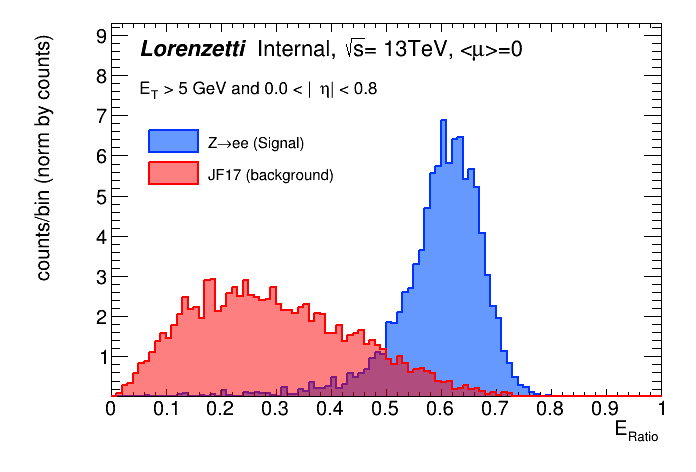

In [10]:
sgn = zee.loc[ (zee['et'] > 5*GeV) & (abs(zee['eta']) <= 0.8) ]['eratio'].values
bkg = jets.loc[ (jets['et'] > 5*GeV) & (abs(jets['eta']) <= 0.8) ]['eratio'].values

print(sgn.mean())
print(bkg.mean())
d_zee, d_jets = make_1d_histograms(sgn, bkg, 100, 0, 1)
fig = rpl.create_canvas('my_canvas')
rpl.add_hist( d_zee,'same' )
rpl.add_hist( d_jets ,'same' )
rpl.set_xlabel('E_{Ratio}')
rpl.set_ylabel('counts/bin (norm by counts)')
rpl.set_lorenzetti_label(0.2,0.88,'Internal, #sqrt{s}= 13TeV, <#mu>=0')
rpl.add_text(0.2, 0.8, 'E_{T} > 5 GeV and 0.0 < |#eta| < 0.8', textsize=0.04)
legends = ['Z#rightarrowee (Signal)', 'JF17 (background)']
add_legend( 0.2,0.6, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
rpl.format_canvas_axes( YTitleOffset=1.3) 
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.35) 
fig.show()
fig.savefig('output/simulation_Zee_vs_jets_eratio.pdf')

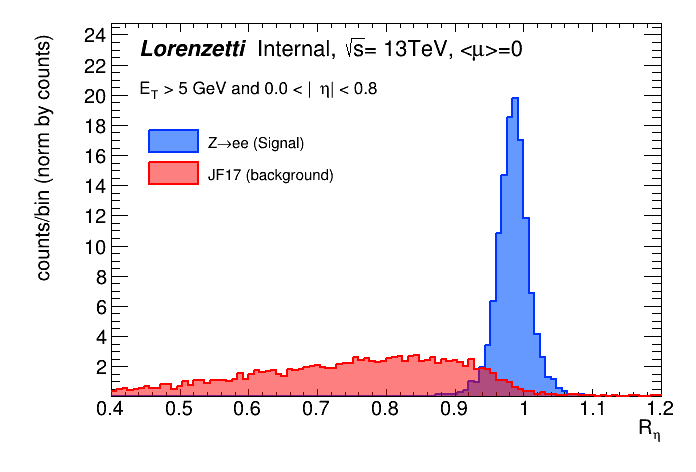

In [11]:
sgn = zee.loc[ (zee['et'] > 5*GeV) & (abs(zee['eta']) <= 0.8) ]['reta'].values
bkg = jets.loc[ (jets['et'] > 5*GeV) & (abs(jets['eta']) <= 0.8) ]['reta'].values

d_zee, d_jets = make_1d_histograms(sgn, bkg, 100, 0.4, 1.2)
fig = rpl.create_canvas('my_canvas')
rpl.add_hist( d_zee,'same' )
rpl.add_hist( d_jets ,'same' )
rpl.set_xlabel('R_{#eta}')
rpl.set_ylabel('counts/bin (norm by counts)')
rpl.set_lorenzetti_label(0.2,0.88,'Internal, #sqrt{s}= 13TeV, <#mu>=0')
rpl.add_text(0.2, 0.8, 'E_{T} > 5 GeV and 0.0 < |#eta| < 0.8', textsize=0.04)
legends = ['Z#rightarrowee (Signal)', 'JF17 (background)']
add_legend( 0.2,0.6, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
rpl.format_canvas_axes( YTitleOffset=1.3) 
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.25) 
fig.show()
fig.savefig('output/simulation_Zee_vs_jets_reta.pdf')

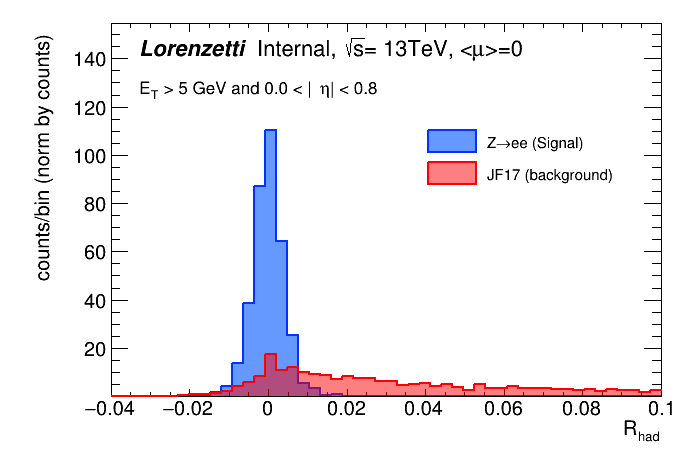

In [94]:
sgn = zee.loc[ (zee['et'] > 5*GeV) & (abs(zee['eta']) <= 0.8) ]['rhad'].values
bkg = jets.loc[ (jets['et'] > 5*GeV) & (abs(jets['eta']) <= 0.8) ]['rhad'].values
d_zee, d_jets = make_1d_histograms(sgn, bkg, 50, -0.04, 0.1)
fig = rpl.create_canvas('my_canvas')
rpl.add_hist( d_zee,'same' )
rpl.add_hist( d_jets ,'same' )
rpl.set_xlabel('R_{had}')
rpl.set_ylabel('counts/bin (norm by counts)')
rpl.set_lorenzetti_label(0.2,0.88,'Internal, #sqrt{s}= 13TeV, <#mu>=0')
rpl.add_text(0.2, 0.8, 'E_{T} > 5 GeV and 0.0 < |#eta| < 0.8', textsize=0.04)
legends = ['Z#rightarrowee (Signal)', 'JF17 (background)']
add_legend( 0.6,0.6, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
rpl.format_canvas_axes( YTitleOffset=1.3) 
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.4) 
fig.show()
fig.savefig('output/simulation_Zee_vs_jets_rhad.pdf')

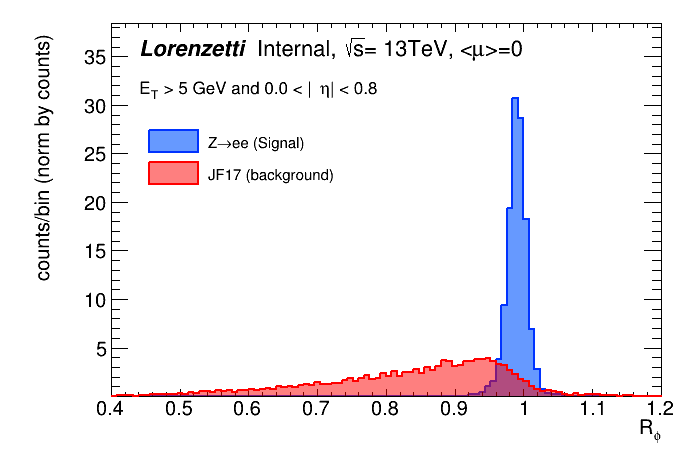

In [12]:
sgn = zee.loc[ (zee['et'] > 5*GeV) & (abs(zee['eta']) <= 0.8) ]['rphi'].values
bkg = jets.loc[ (jets['et'] > 5*GeV) & (abs(jets['eta']) <= 0.8) ]['rphi'].values
d_zee, d_jets = make_1d_histograms(sgn, bkg, 100, 0.4, 1.2)
fig = rpl.create_canvas('my_canvas')
rpl.add_hist( d_zee,'same' )
rpl.add_hist( d_jets ,'same' )
rpl.set_xlabel('R_{#phi}')
rpl.set_ylabel('counts/bin (norm by counts)')
rpl.set_lorenzetti_label(0.2,0.88,'Internal, #sqrt{s}= 13TeV, <#mu>=0')
rpl.add_text(0.2, 0.8, 'E_{T} > 5 GeV and 0.0 < |#eta| < 0.8', textsize=0.04)
legends = ['Z#rightarrowee (Signal)', 'JF17 (background)']
add_legend( 0.2,0.6, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
rpl.format_canvas_axes( YTitleOffset=1.3) 
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.25) 
fig.show()
fig.savefig('output/simulation_Zee_vs_jets_rphi.pdf')

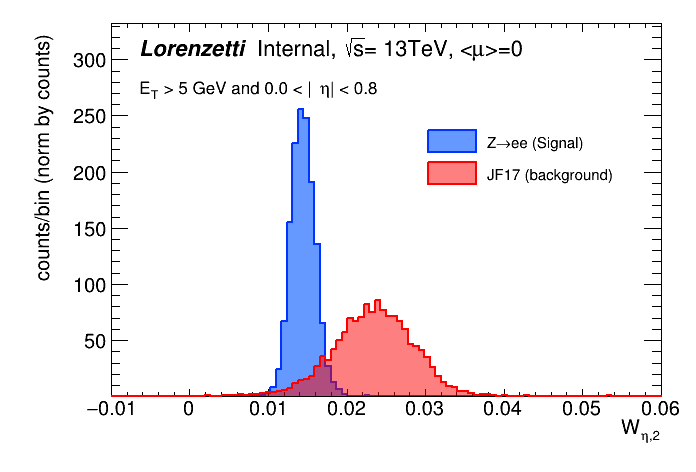

In [13]:
sgn = zee.loc[ (zee['et'] > 5*GeV) & (abs(zee['eta']) <= 0.8) ]['weta2'].values
bkg = jets.loc[ (jets['et'] > 5*GeV) & (abs(jets['eta']) <= 0.8) ]['weta2'].values
d_zee, d_jets = make_1d_histograms(sgn, bkg, 100, -0.01, 0.06)
fig = rpl.create_canvas('my_canvas')
rpl.add_hist( d_zee,'same' )
rpl.add_hist( d_jets ,'same' )
rpl.set_xlabel('W_{#eta,2}')
rpl.set_ylabel('counts/bin (norm by counts)')
rpl.set_lorenzetti_label(0.2,0.88,'Internal, #sqrt{s}= 13TeV, <#mu>=0')
rpl.add_text(0.2, 0.8, 'E_{T} > 5 GeV and 0.0 < |#eta| < 0.8', textsize=0.04)
legends = ['Z#rightarrowee (Signal)', 'JF17 (background)']
add_legend( 0.6,0.6, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
rpl.format_canvas_axes( YTitleOffset=1.3) 
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.3) 
fig.show()
fig.savefig('output/simulation_Zee_vs_jets_weta2.pdf')

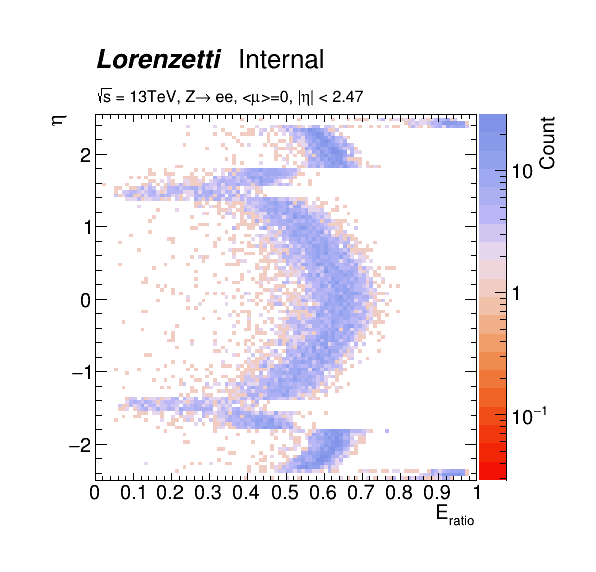

In [14]:
sgn_eta = zee.loc[ (zee['et'] > 5*GeV) & (abs(zee['eta']) <= 2.47) ]['eta'].values
sgn_eratio = zee.loc[ (zee['et'] > 5*GeV) & (abs(zee['eta']) <= 2.47) ]['eratio'].values
fig = rpl.create_canvas('my_canvas','',600, 600)
canvas = fig.get_pad()
canvas.SetRightMargin(0.2)
canvas.SetTopMargin(0.2)
canvas.SetLogz()
gStyle.SetPalette(kBlackBody)
h1 = rpl.hist2d.new( 'zee', 100, 0, 1, 100, -2.5, 2.5)
rpl.hist2d.fill( h1, sgn_eratio, sgn_eta )
rpl.add_hist( h1, 'colz')
rpl.set_lorenzetti_label(0.16,0.88,'Internal')
rpl.add_text(0.16, 0.82, '#sqrt{s} = 13TeV, Z#rightarrow ee, <#mu>=0, |#eta| < 2.47', textsize=0.03)
rpl.set_xlabel('E_{ratio}')
rpl.set_ylabel('#eta')
h1.GetZaxis().SetTitle("Count")
#legends = ['Z#rightarrowee (Signal)', 'JF17 (background)']
#add_legend( 0.6,0.6, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
rpl.format_canvas_axes(YTitleOffset=1, ZTitleOffset=1.1) 
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.3) 
fig.show()
fig.savefig('output/simulation_Zee_eratio_vs_eta.pdf')

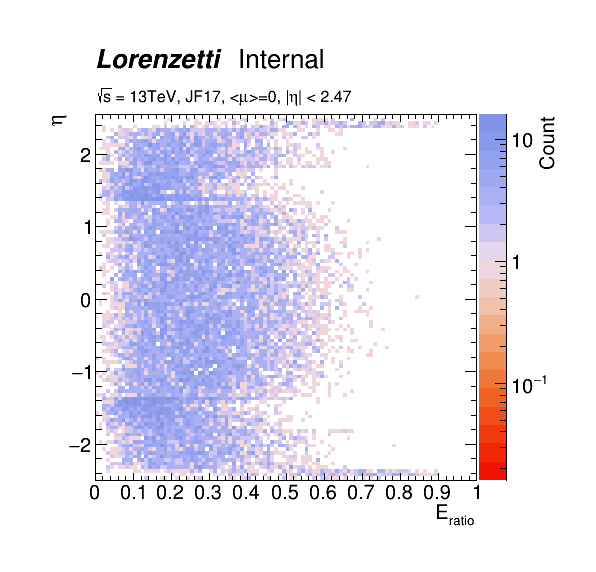

In [15]:
bkg_eta = jets.loc[ (jets['et'] > 5*GeV) & (abs(jets['eta']) <= 2.47) ]['eta'].values
bkg_eratio = jets.loc[ (jets['et'] > 5*GeV) & (abs(jets['eta']) <= 2.47) ]['eratio'].values
fig = rpl.create_canvas('my_canvas','',600, 600)
canvas = fig.get_pad()
canvas.SetRightMargin(0.2)
canvas.SetTopMargin(0.2)
canvas.SetLogz()
gStyle.SetPalette(kBlackBody)
h1 = rpl.hist2d.new( 'zee', 100, 0, 1, 100, -2.5, 2.5)
rpl.hist2d.fill( h1, bkg_eratio, bkg_eta )
rpl.add_hist( h1, 'colz')
rpl.set_lorenzetti_label(0.16,0.88,'Internal')
rpl.add_text(0.16, 0.82, '#sqrt{s} = 13TeV, JF17, <#mu>=0, |#eta| < 2.47', textsize=0.03)
rpl.set_xlabel('E_{ratio}')
rpl.set_ylabel('#eta')
h1.GetZaxis().SetTitle("Count")
#legends = ['Z#rightarrowee (Signal)', 'JF17 (background)']
#add_legend( 0.6,0.6, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
rpl.format_canvas_axes(YTitleOffset=1, ZTitleOffset=1.1) 
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.3) 
fig.show()
fig.savefig('output/simulation_jets_eratio_vs_eta.pdf')

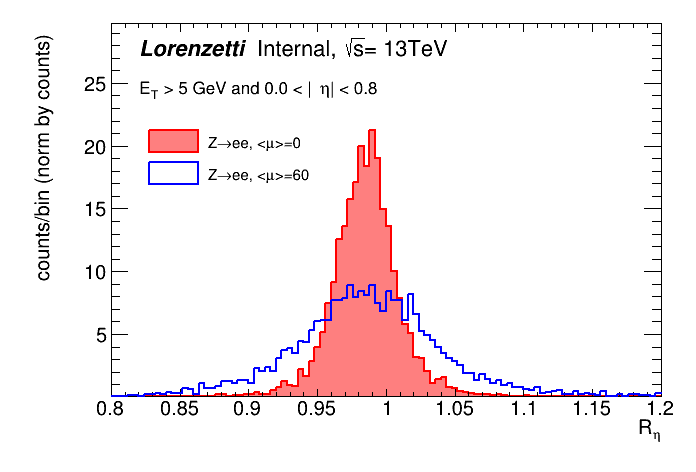

In [65]:
sgn    = zee.loc[ (zee['et'] > 5*GeV) & (abs(zee['eta']) <= 0.8) ]['reta'].values
sgn_mb = zee_mb.loc[ (zee_mb['et'] > 5*GeV) & (abs(zee_mb['eta']) <= 0.8) ]['reta'].values
d_zee, d_zee_mb = make_1d_histograms(sgn, sgn_mb, 100, 0.8, 1.2)



d_zee.SetLineColor(kRed)
d_zee.SetFillColor(rpl.get_color(kRed, 0.5))
d_zee_mb.SetLineColor(kBlue)
d_zee_mb.SetFillColor(0)
#d_zee_mb.SetFillColor(rpl.get_color(kGray, 0.2))


fig = rpl.create_canvas('my_canvas')
rpl.add_hist( d_zee,'same' )
rpl.add_hist( d_zee_mb ,'same' )
rpl.set_xlabel('R_{#eta}')
rpl.set_ylabel('counts/bin (norm by counts)')
rpl.set_lorenzetti_label(0.2,0.88,'Internal, #sqrt{s}= 13TeV')
rpl.add_text(0.2, 0.8, 'E_{T} > 5 GeV and 0.0 < |#eta| < 0.8', textsize=0.04)
add_legend( 0.2,0.6, ['Z#rightarrowee, <#mu>=0', 'Z#rightarrowee, <#mu>=60'])
rpl.format_canvas_axes( YTitleOffset=1.3) 
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.4)
fig.show()
fig.savefig('output/simulation_Zee_mu60_reta.pdf')

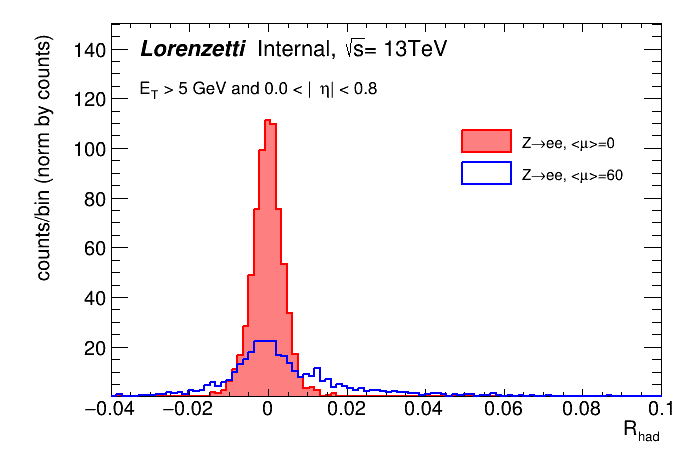

In [83]:
sgn    = zee.loc[ (zee['et'] > 5*GeV) & (abs(zee['eta']) < 0.8)]['rhad'].values
sgn_mb = zee_mb.loc[ (zee_mb['et'] > 5*GeV) & (abs(zee['eta']) < 0.8)]['rhad'].values
d_zee, d_zee_mb = make_1d_histograms(sgn, sgn_mb, 100, -0.04, 0.1)


d_zee.SetLineColor(kRed)
d_zee.SetFillColor(rpl.get_color(kRed, 0.5))
d_zee_mb.SetLineColor(kBlue)
d_zee_mb.SetFillColor(0)




fig = rpl.create_canvas('my_canvas')
rpl.add_hist( d_zee,'same' )
rpl.add_hist( d_zee_mb ,'same' )
rpl.set_xlabel('R_{had}')
rpl.set_ylabel('counts/bin (norm by counts)')
rpl.set_lorenzetti_label(0.2,0.88,'Internal, #sqrt{s}= 13TeV')
rpl.add_text(0.2, 0.8, 'E_{T} > 5 GeV and 0.0 < |#eta| < 0.8', textsize=0.04)
legends = ['Z#rightarrowee (Signal)', 'JF17 (background)']
add_legend( 0.65,0.6, ['Z#rightarrowee, <#mu>=0', 'Z#rightarrowee, <#mu>=60'])
rpl.format_canvas_axes( YTitleOffset=1.3) 
rpl.fix_yaxis_ranges( ignore_zeros=True, ignore_errors=True , ymaxf=1.35) 
fig.show()
fig.savefig('output/simulation_Zee_mu60_rhad.pdf')